After watching the film *Arrival*, I developed a deep appreciation for the field of linguistics (also my favorite movie of 2016). Human language is the most unstructured type of data, and yet we effortlessly parse and interpret it, and even generate our own. On the other hand, understanding everyday language is a significant challenge for machines; this is the focus of **natural language processing** (NLP)&mdash;the crossroads between linguistics and AI. In this post, we'll make use of some NLP concepts and combine them with machine learning to build a spam filter for SMS text messages.
<!-- TEASER_END -->

In the 1950s, Alan Turing conjectured if a machine can fool a human into believing that he/she is speaking with another human, the machine exhibits intelligence&mdash;the iconic Turing test. Recently, a machine arguably passed the Turing test [for the first time](http://www.reading.ac.uk/news-and-events/releases/PR583836.aspx); the milestone was largely attributed to advances in NLP. If you've ever wondered how Siri or Google recognizes your voice, makes sense of a semantically nebulous question, such as "How did the Celtics do?", and returns an accurate response, that's also NLP in action! The war on spam is another.

Before Gmail implemented its incredible spam filter, I remember crafting an elaborate set of if/then rules for words typically found in spam. Not surprisingly, it was tedious and prone to mistakes. Nowadays, no one hand codes a spam filter&mdash;we train machines to do the job! But email spam is different from SMS message spam; we tend to speak more casually on our phones, using more slang, incomplete sentences, or even concocting words and phrases. Let's see what machine learning can do for SMS message spam.

# Table of contents
1. [Inspecting the dataset](#cell1)
2. [Text preprocessing](#cell2)
3. [Feature engineering](#cell3)
4. [Training and evaluating a model](#cell4)
5. [What terms are the top predictors of spam?](#cell5)
6. [How to improve the model](#cell6)

In [1]:
# Load the required packages
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, svm
from sklearn.model_selection import (
    train_test_split, learning_curve, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score)

# Improve the readability of figures
# sns.set_context('notebook', font_scale=1.4)
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id="cell1"></a>
# 1. Inspecting the dataset

While browsing the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection), I discovered a dataset chock-full of anonymous SMS text messages. Let's begin by loading it and taking a look around.

In [2]:
# Load the dataset
df = pd.read_table('SMSSpamCollection', header=None)

# Display the first five rows
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


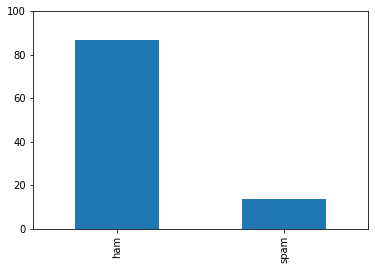

In [3]:
(df[0].value_counts(normalize=True) * 100).plot.bar()
plt.ylim(0,100)
plt.savefig('sample.png', dpi=500)

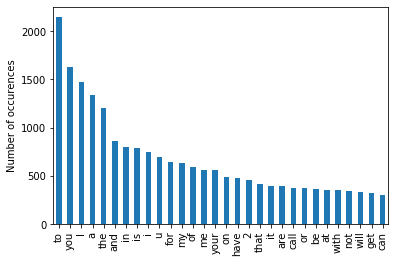

In [4]:

# Visualization of the most frequent words of the dataset
count1 = Counter(" ".join(df[1]).split()).most_common(30)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words", 1 : "count"})
fig = plt.figure()
ax = fig.add_subplot(111)
df1.plot.bar(ax=ax, legend = False)
xticks = np.arange(len(df1["words"]))
ax.set_xticks(xticks)
ax.set_xticklabels(df1["words"])
ax.set_ylabel('Number of occurences')
plt.show()

In [5]:
# Wordcloud paramters
wc_height, wc_width = (512, 1024)
wc_bckp_color = 'white'
wc_max_words = 200
wc_max_font_size = 110
random_state = 42
wc_figsize = (12, 10)

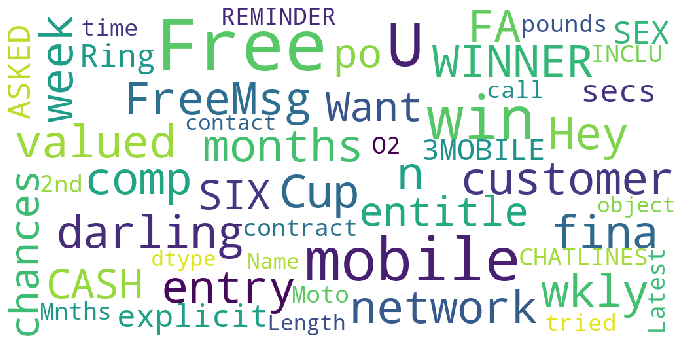

In [6]:
# Extracting spam messages from DataFrame
spam_df = df.loc[df[0] == 'spam']

# Creating wordcloud for spam
spam_wc = WordCloud(
    height=wc_height, width=wc_width, background_color=wc_bckp_color,
    max_words=wc_max_words, max_font_size=wc_max_font_size,
    random_state=random_state
).generate(str(spam_df[1]))

# Display the wordcloud
fig = plt.figure(figsize=wc_figsize)
plt.imshow(spam_wc)
plt.axis('off')
plt.show()

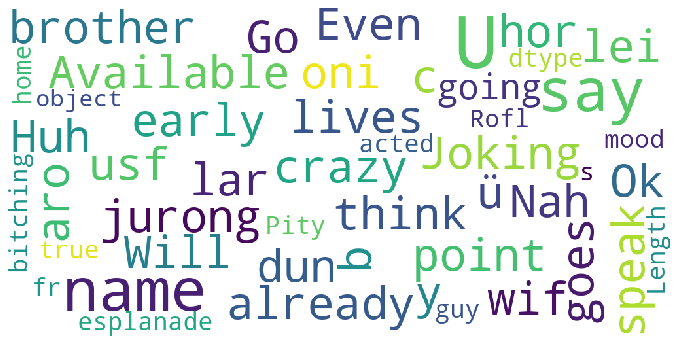

In [7]:
# Extracting ham messages from DataFrame
ham_df = df.loc[df[0] == 'ham']

# Creating wordcloud for ham
ham_wc = WordCloud(
    height=wc_height, width=wc_width, background_color=wc_bckp_color,
    max_words=wc_max_words, max_font_size=wc_max_font_size,
    random_state=random_state
).generate(str(ham_df[1]))

# Display the wordcloud
fig = plt.figure(figsize=wc_figsize)
plt.imshow(ham_wc)
plt.axis('off')
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5572 non-null   object
 1   1       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


We have a collection of text data known as a **corpus**. Specifically, there are 5,572 SMS messages written in English, serving as training examples. The first column is the target variable containing the class labels, which tells us if the message is spam or ham (aka not spam). The second column is the SMS message itself, stored as a string. 

Since the target variable contains discrete values, this is a classification task. Let's start by placing the target variable in its own table and checking out how the two classes are distributed.

In [9]:
# Store the target variable
y = df[0]

# Display the class distribution
y.value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

It looks like there are far fewer training examples for spam than ham&mdash;we'll take this imbalance into account in the analysis. In addition, we need to encode the class labels in the target variable as numbers to ensure compatibility with some models in Scikit-learn. Because we have binary classes, let's use `LabelEncoder` and set `'spam'` = `1` and `'ham'` = `0`.

In [10]:
# Encode the class labels as numbers
le = LabelEncoder()
y_enc = le.fit_transform(y)

Next, let's place the SMS message data into its own table.

In [11]:
# Store the SMS message data
raw_text = df[1]

We're sitting on a mountain of text data but it might as well be gibberish since a machine only understands numbers. How can we convert this corpus into useful numerical features so we can train a classifier? This is where NLP comes in.

<a id="cell2"></a>
# 2. Text preprocessing

There are many feature engineering strategies for transforming text data into features. Some involve assigning each unique word-like term to a feature and counting the number of occurrences per training example. However, if we were to perform this strategy right now, we'd end up with an absurd number of features, a result of the myriad possible terms. The classifier would take too long to train and likely overfit. As a result, **each NLP problem requires a tailored approach to determine which terms are relevant and meaningful**. 

For the remainder of this section, I'll walk through my preprocessing strategy, which relies heavily on [regular expressions](http://regexr.com/).

## Normalization

Let's begin by taking a step back and examining the terms of a hypothetical SMS message.

In [12]:
example = """  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in 
NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 
555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """

I'd definitely deem this as spam. But clearly there's a lot going on here: phone numbers, emails, website URLs, money amounts, and gratuitous whitespace and punctuation. Some terms are randomly capitalized, others are in all-caps. Since these terms might show up in any one of the training examples in countless forms, we need a way to ensure each training example is on equal footing via a preprocessing step called **normalization**. 

Instead of removing the following terms, for each training example, let's replace them with a specific string.
* Replace email addresses with `'emailaddr'`
* Replace URLs with `'httpaddr'`
* Replace money symbols with `'moneysymb'`
* Replace phone numbers with `'phonenumbr'`
* Replace numbers with `'numbr'`

Next, we'll remove all punctuation since "today" and "today?" refer to the same word. In addition, let's collapse all whitespace (spaces, line breaks, tabs) into a single space. Furthermore, we'll eliminate any leading or trailing whitespace.

We'll also need to treat the words "there", "There" and "ThERe" as the same word. Therefore, let's lowercase the entire corpus.

## Removing stop words

Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called **stop words** and should be filtered out. The Natural Language Toolkit (NLTK), a popular Python library for NLP, provides common stop words.

This list of stop words is literally stored in a Python `list`. If instead we convert it to a Python `set`, iterating over the stop words will go *much* faster, and shave time off this preprocessing step.

## Stemming

It's likely the corpus contains words with various suffixes such as "distribute", "distributing", "distributor" or "distribution". We can replace these four words with just "distribut" via a preprocessing step called **stemming**. There are numerous stemming strategies, some more aggressive than others. Instead of painstakingly building a stemmer from scratch, let's use one from NLTK called the Porter stemmer.

In [13]:
# Remove word stems using a Porter stemmer
# porter = nltk.PorterStemmer()
# processed = processed.apply(lambda x: ' '.join(
#     porter.stem(term) for term in x.split())
# )

Because we have so many preprocessing steps, let's combine them all into a handy function that takes in a string and cleans it up.

In [14]:
# Remove word stems using a Porter stemmer
stop_words = stopwords.words('english')
porter = nltk.PorterStemmer()
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

As a sanity check, let's confirm this function yields the same results as the previous series of steps.

In [15]:
# (processed == raw_text.apply(preprocess_text)).all()

In [16]:
processed = raw_text.apply(preprocess_text)

Additionally, let's test `preprocess_text()` on the hypothethical SMS message from earlier.

In [51]:
preprocess_text(example)

'congratl numbr ticket hamilton nyc httpaddr worth moneysymbnumbr call phonenumbr send messag emailaddr get ticket'

What a change! It looks like the preprocessing strategy is working. A quick technical note before we move on: since this was the first time I encountered regular expressions, I learned the hard way that mindful usage of the lazy quantifier `?` is crucial&mdash;incorporating it reduced the total preprocessing time from 1 hour to *2 seconds!*

<a id="cell3"></a>
# 3. Feature engineering

Now that we've enriched the corpus for meaningful terms, we're ready to construct features. Let's begin by breaking apart the corpus into a vocabulary of unique terms&mdash;a process called **tokenization**. However, there are several ways to approach this step. 

## Tokenization

We can tokenize individual terms and generate what's called a **bag of words model**. You may notice this model has a glaring pitfall: it fails to capture the innate structure of human language. Under this model, the following sentences have the same feature vector although they convey dramatically different meanings.

* Does steak taste delicious?
* Steak does taste delicious.

Alternatively, we can tokenize every sequence of $n$ terms called $n$-grams. For example, tokenizing adjacent pairs of words yields bigrams. The **$n$-gram model** preserves word order and can potentially capture more information than the bag of words model. 

To get the best of both worlds, let's tokenize unigrams *and* bigrams. As an example, unigrams and bigrams for "The quick brown fox" are "The", "quick", "brown", "fox", "The quick", "quick brown" and "brown fox".

## Implementing the tf-idf statistic

Having selected a tokenization strategy, the next step is assign each $n$-gram to a feature and then compute the $n$-gram's frequency using some statistic. Again, we have options.

One statistic called **term frequency (tf)** tallies the occurrences of each $n$-gram for every training example. However, some $n$-grams will undoubtedly show up often in any given SMS message, while others rarely appear in the overall corpus but show up frequently in certain *subsets* of messages such as spam. Therefore, to emphasize the latter, more interesting set of $n$-grams, we'll downweight the term frequency with **inverse document frequency (idf)**, which is calculated by logarithmically scaling the inverse of the fraction of training examples that contain a given term. Combining these two statistics yields the tf-idf statistic:

$$\textrm{tf-idf}(t, i) = \textrm{tf}(t, i) \times \textrm{idf}(t) = \textrm{tf}(t, i) \times \log\bigg(\frac{M}{m_t}\bigg)$$

where $\textrm{tf}(t,i)$ is the term frequency for term $t$ in the $i$th training example, $M$ is the total number of training examples, and $m_t$ is the number of training examples that contain the term $t$. 

Scikit-learn has an off-the-shelf tool called `TfidfVectorizer` that performs $n$-gram tokenization and also computes the tf-idf statistic. Two technical details regarding `TfidfVectorizer`: a) the tf-idf statistic is computed [slightly differently](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) to avoid division by zero, and b) the computed tf-idf values for each training example are subsequently [normalized](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

**Finally, we're equipped to transform a corpus of text data into a matrix of numbers with one row per training example and one column per $n$-gram.**

In [53]:
processed

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri numbr wkli comp win fa cup final tk...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    numbrnd time tri numbr contact u u moneysymbnu...
5568                              ü b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: 1, Length: 5572, dtype: object

In [56]:
processed.to_pickle("./dummy.pkl")

In [18]:
# Construct a design matrix using an n-gram model and a tf-idf statistics
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(processed)

Let's take a look at the dimensions of the `X_ngrams` matrix.

In [19]:
X_ngrams.shape

(5572, 36348)

Holy cow, that's one massive matrix! It looks like the tokenization process extracted 36,348 unigrams and bigrams from the corpus; each one defines a feature. Since each training example only makes use of a tiny fraction of the complete $n$-gram vocabulary, `X_ngrams` mostly consists of zeros and is called a **sparse matrix**. To perform linear algebra computations rapidly on such a large sparse matrix, it'd be more efficient to store only the non-zero values while maintaining the structure. Fortunately, `TfidfVectorizer` utilizes the SciPy library to do *exactly* this!

<a id="cell4"></a>
# 4. Training and evaluating a model

That was a lot of prep work and we haven't even done any machine learning yet, but all of it crucial for building a robust classifier. **Not only is a model only as good as the data it's trained on, but meticulous feature engineering can beat having a fancy model.** We'll be a training a state of the art classifier called **support vector machines (SVM)**. In a nutshell, this model attempts to find the hyperplane that best separates the two classes. 

In particular, I've elected to use SVM with a *linear kernel* because text data contains a large number of features (we have over 30,000!); using a nonlinear kernel would be [computationally expensive](http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf). In addition, text data is typically [linearly separable to begin with](https://link.springer.com/chapter/10.1007/BFb0026683). Finally, we'll use `svm.LinearSVC()` instead of `svm.SVC(kernel='linear')` because the former relies on a library whose [algorithmic complexity](https://stackoverflow.com/questions/11508788/whats-the-difference-between-libsvm-and-liblinear) is $O(n)$ instead of $O(n^2)$ or $O(n^3)$, meaning much faster. 

## Preliminary analysis

For a rudimentary understanding of how well SVM performs on the dataset, let's start with the hold-out method: an 80/20 training and test set split. **Remember to never evaluate a model on the data used to train it!** In addition, since the classes are imbalanced, we'll incorporate stratification and use the $F_1$ score as the performance metric.

In [20]:
# # Prepare the training and test sets using an 80/20 split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_ngrams,
#     y_enc,
#     test_size=0.2,
#     random_state=42,
#     stratify=y_enc
# )

# # Train SVM with a linear kernel on the training set
# clf = svm.LinearSVC(loss='hinge')
# clf.fit(X_train, y_train)

# # Evaluate the classifier on the test set
# y_pred = clf.predict(X_test)

# # Compute the F1 score
# metrics.f1_score(y_test, y_pred)

Not a bad start, but we really need to run cross-validation to gauge whether this performance is consistent. While we're here, let's use a **confusion matrix** to take a peek at what types of mistakes the classifier is making. 

In [21]:
# # Display a confusion matrix
# pd.DataFrame(
#     metrics.confusion_matrix(y_test, y_pred),
#     index=[['actual', 'actual'], ['spam', 'ham']],
#     columns=[['predicted', 'predicted'], ['spam', 'ham']]
# )

It looks when the classifier does make a mistake, it's typically a false positive:  flagging an SMS message as spam when it's actually not. Not exactly ideal but then again, this is just a single training/test set split.

## Diagnosing the model with learning curves

Because we have so many features, it's prudent to determine whether the classifier suffers from high variance and is overfitting. We can assess the situation by plotting **learning curves**. Here's the procedure:

1. Split the entire dataset $k$ times into a training and validation set
2. For each split, train the model on *subsets* of the training set, each with fewer training examples
3. Evaluate the model on the validation set and each subset of the training set
4. Average the model performance across the $k$ splits for both training and validation sets

Specifically, we'll use 10-fold cross-validation (80/20 split) *without regularization*. For each fold, we'll train the classifier on 10 different dataset sizes, starting with 500 training examples. Fortunately, Scikit-learn has a convenient tool that computes learning curves in one go.

In [22]:
# # Select 10 different sizes of the entire dataset
# sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')

# # Compute learning curves without regularization for the SVM model
# train_sizes, train_scores, valid_scores = learning_curve(
#     estimator=svm.LinearSVC(loss='hinge', C=1e10),
#     X=X_ngrams,
#     y=y_enc,
#     train_sizes=sample_space,
#     cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),
#     scoring='f1',
#     n_jobs=-1
# )

I love the Seaborn library for visualization but like other high-level plotting libraries, it requires data to be in ["tidy" format](https://www.jstatsoft.org/article/view/v059i10) where each variable forms a column and each observation forms a row. Trust me, tidy data make data analysis and plotting *so much* easier. Let's define a function that combines `train_scores` and `valid_scores` into a single tidy table.

In [23]:
# def make_tidy(sample_space, train_scores, valid_scores):
#     # Join train_scores and valid_scores, and label with sample_space
#     messy_format = pd.DataFrame(
#         np.stack((sample_space, train_scores.mean(axis=1),
#                   valid_scores.mean(axis=1)), axis=1),
#         columns=['# of training examples', 'Training set', 'Validation set']
#     )
    
#     # Re-structure into into tidy format
#     return pd.melt(
#         messy_format,
#         id_vars='# of training examples',
#         value_vars=['Training set', 'Validation set'],
#         var_name='Scores',
#         value_name='F1 score'
#     )

We're now ready to use Seaborn to plot learning curves for the classifier.

In [24]:
# # Initialize a FacetGrid object using the table of scores and facet on
# # the type of score
# g = sns.FacetGrid(
#     make_tidy(sample_space, train_scores, valid_scores), hue='Scores', height=5
# )

# # Plot the learning curves and add a legend
# g.map(plt.scatter, '# of training examples', 'F1 score')
# g.map(plt.plot, '# of training examples', 'F1 score').add_legend();

I love learning curves&mdash;they're teeming with information! Notice the performance on the training set is near perfect regardless of dataset size, which makes sense because we're evaluating the classifier on the same data used to train it. At first, it looks like the classifier is suffering from high variance and is overfitting since the validation scores never reach the same level. However, taking a closer look at the scale of the $y$-axis makes me believe this issue isn't that pronounced. 

Nevertheless, since the validation scores improve with more training examples, an obvious next step is to acquire more data points. In addition, we could try a smaller set of features by only using bigrams, not unigrams. Finally, it's worth tuning the regularization hyperparameter.

## Using nested cross-validation to minimize information leakage

To optimize hyperparameters, we can use Scikit-learn's `GridSearchCV` tool, which trains a series of candidate models using every combination of hyperparameters, evaluates each model using $k$-fold cross-validation, and then reports the "winning" model and its hyperparameter combination that yielded the best performance. However, we can't report this value as an unbiased estimate of the model's performance because we repeatedly reused the same data for cross-validation&mdash;we potentially "leaked" information across the candidate models!

What we *can* do is utilize **nested cross-validation** to alleviate this issue. In this procedure, we implement $k$-fold cross-validation to train $k$ models (the outer loop). Using the *training set* of each fold, we perform `GridSearchCV` to tune the hyperparameters and select a winning model (the inner loop). Then, using the *validation set* of each fold, we evaluate the performance of the winning model developed in the inner loop. Finally, by computing the mean of this performance value across the $k$ folds, we can report a robust estimate of the model's performance. This can be a bit confusing so I recommend taking a glance at [this visual representation](https://mlr-org.github.io/mlr-tutorial/devel/html/nested_resampling/index.html) of what's going on.

Using nested cross-validation, let's test a range of 20 values for the regularization hyperparameter and use 10-fold cross-validation to assess the classifier's performance.

In [25]:
# Select a range of values to test the regularization hyperparameter
param_grid = [{'C': np.logspace(-4, 4, 20)}]

# Inner cross-validation loop to tune the hyperparameter
grid_search = GridSearchCV(
    estimator=svm.LinearSVC(loss='hinge'),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

# Outer cross-validation loop to assess the model's performance
scores = cross_val_score(
    estimator=grid_search,
    X=X_ngrams,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    scoring='f1',
    n_jobs=-1
)

scores

array([0.91636364, 0.94366197, 0.95104895, 0.93661972, 0.94736842,
       0.93286219, 0.91039427, 0.90510949, 0.9057971 , 0.94699647])

The scores across the 10 folds demonstrate the classifier's performance is moderately consistent&mdash;it depends on what level of variation we're comfortable with. Finally, let's compute the mean score to report an estimate of the classifier's performance.

In [26]:
scores.mean()

0.9296222211583224

<a id="cell5"></a>
# 5. What terms are the top predictors of spam?

I'm incredibly curious about which $n$-grams are the most predictive of spam. But first, we need to use the optimal regularization hyperparameter to train the classifier on the *whole* dataset in order to provide it as much information as possible.

In [27]:
# Identify the optimal regularization hyperparameter
grid_search.fit(X_ngrams, y_enc)

# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, y_enc);

In [28]:
import pickle
pickle.dump(final_clf, open('svm_model.pkl', 'wb'))

Now, let's take a look at the top 20 $n$-grams that are most predictive of spam.

In [29]:
# # Display the features with the highest weights in the SVM model
# pd.Series(
#     final_clf.coef_.T.ravel(),
#     index=vectorizer.get_feature_names()
# ).sort_values(ascending=False)[:20]

There are a few obvious ones at the top: `phonenumbr`, `txt`, `moneysymbnumber` (money amount), `call phonenumbr`, `claim`, `video`, `free`, `stop`, `credit` and `order`. However, the [data description](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) points out the majority of the spam in this dataset originated from a British website, while the most of the ham came from Singaporean students. This is quite concerning because the lexicon in SMS messages varies dramatically across different national, cultural and age demographics. This sampling bias may adversely affect the validity of the classifier. Remember what I said earlier about the data you use to train a model?

To finish up, let's write up a function that'll decide whether a string is spam or not, and apply it on the hypothetical message from earlier.

In [30]:
def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'spam'
    else:
        return 'not spam'

In [31]:
spam_filter(example)

'spam'

The classifier decided that message was indeed spam. Do you agree? Let's try a real SMS message that I just received (spoiler: it's not spam).

In [32]:
spam_filter('Ohhh, but those are the best kind of foods')

'not spam'

In [57]:
processed2 = pd.read_pickle("./dummy.pkl")

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri numbr wkli comp win fa cup final tk...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    numbrnd time tri numbr contact u u moneysymbnu...
5568                              ü b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: 1, Length: 5572, dtype: object

In [58]:
stop_words1 = stopwords.words('english')
porter1 = nltk.PorterStemmer()
def preprocess_text1(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter1.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words1)
    )

vectorizer1 = TfidfVectorizer(ngram_range=(1, 2)).fit(processed2)

load_model = pickle.load(open('svm_model.pkl', 'rb'))

# st.subheader("Let's classify this and see what it tells : 'WINNER!! This is the secret code to unlock the money: C3421.'")
text = """  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in 
NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 
555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """
if load_model.predict(vectorizer1.transform([preprocess_text(text)])):
    print('spam')
else:
    print('not spam')

spam


Cool! Go ahead and try your own messages!

<a id="cell6"></a>
# 6. How to improve the model

We can attempt to boost the classifier's performance but there's simply too many different avenues. However, I'd like to highlight some of the prominent ones.

1. Text preprocessing
    * I handcrafted the regular expressions in this post (by no means an expert!) but I'm certain we can increase their matching performance and efficiency. It may be also be worthwhile using regex to normalize other terms such as dates, times, slang, etc.
    * I selected the Porter stemmer here but comparing the performance with the Lancaster stemmer would be interesting. However, stemming can be crude and chop off suffixes haphazhardly&mdash;a better alternative is **lemmatization**. For example, the word "worse" reduces to "bad".
    * We ignored the innate features of each training example such as message length, average word length, distribution of the various forms of punctuation, all-caps frequency, etc. Each of these may enhance the classifier's predictive capacity.
2. Feature engineering
    * I discovered Scikit-learn computes term frequency by simply counting each term. Because SMS messages come in a variety of lengths, normalizing the term frequency to the message length is a good idea.
    * You may have noticed most of the top 20 terms listed above are unigrams. This hints that bigrams aren't as useful in this problem&mdash;a bag of words model may be sufficient.
3. Machine learning
    * Instead of tuning just the classifier's hyperparameters, we can perform a more exhaustive `GridSearchCV` to compare the use of raw term frequencies instead of tf-idf, or perhaps only tokenizing terms that have a term frequency above/below a threshold. In fact, `TfidfVectorizer` includes many other knobs to play with. In addition, we can test other classifiers such as Naive Bayes, logistic regression or a neural net. All of these different options can be investigated simultaneously by combining `GridSearchCV` with Scikit-learn's [`Pipeline` tool](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html).
    
Of course, the biggest issue in this analysis stems from the dataset itself. We discovered the training examples weren't **independently and identically distributed**, which breaks an [important assumption](https://stats.stackexchange.com/questions/213464/on-the-importance-of-the-i-i-d-assumption-in-statistical-learning) in machine learning. Therefore, to improve the classifier, it's crucial to not only acquire *more* training examples but ensure they all come from the same distribution.

You probably realized by now that each time you reported an email as spam on Gmail, you were providing Google one more training example to help improve their classifier! I hope this post presented a glimpse of what NLP offers and how it can be combined with machine learning to tackle a real world problem. I've only scratched the surface&mdash;can't wait to dive deeper into the linguistics!

If you have any comments, questions or suggestions, kindly visit the [blog post](http://inmachineswetrust.com/posts/sms-spam-filter/) associated with this analysis.